In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#Definición de constantes y condición inicial

G = 6.67e-11
M_Ti = 5.9736e24
R_Ti = 6.3781e6
M_Lu = 0.07349e24
R_Lu = 1.7374e6
d = 3.844e8
w = 2.6617e-6

v_esc = np.sqrt((2*G*M_Ti)/R_Ti)

def lanzamiento(v,phi,theta):
    
    return R_Ti/d, np.deg2rad(phi), v/d*np.cos(np.deg2rad(theta-phi)), (R_Ti/d)*(v/d)*np.sin(np.deg2rad(theta-phi))

In [3]:
#Definición de ecuaciones diferenciales

cons_1 = G*M_Ti/d**3
cons_2 = M_Lu/M_Ti

def r_dot(r,phi,ppr,pphi,t):
    return ppr

def phi_dot(r,phi,ppr,pphi,t):
    return pphi/r**2

def pr_dot(r,phi,ppr,pphi,t):
    
    cons_3 = np.sqrt(1+r**2-(2*r*np.cos((phi)-w*t)) )
    
    return ((pphi**2)/r**3) - (cons_1*( (1/r**2) + (cons_2/(cons_3)**3)*(r-np.cos((phi)-w*t) ) ) )
                             
def pphi_dot(r,phi,ppr,pphi,t):
                             
    cons_3 = np.sqrt(1+r**2-(2*r*np.cos((phi)-w*t)) )
                             
    return ( (-cons_1*cons_2*r)/(cons_3**3) ) * np.sin((phi)-w*t)

In [4]:
#Creación Método Runge-Kutta 4

def GetRK4(f1,f2,f3,f4,r0,t):
    
    h = (t[-1] - t[0])/(len(t)-1)
    
    k1 = np.zeros(4)
    k2 = np.zeros(4)
    k3 = np.zeros(4)
    k4 = np.zeros(4)
    
    y1 = np.zeros(len(t))
    y2 = np.zeros(len(t))
    y3 = np.zeros(len(t))
    y4 = np.zeros(len(t))
    
    y1[0] = r0[0] #r
    y2[0] = r0[1] #phi
    y3[0] = r0[2] #pr
    y4[0] = r0[3] #pphi
        
    for i in range(1,len(t)):
        
        k1[0] = f1(y1[i-1],y2[i-1], y3[i-1], y4[i-1], t[i-1])
        k1[1] = f2(y1[i-1],y2[i-1], y3[i-1], y4[i-1], t[i-1])
        k1[2] = f3(y1[i-1],y2[i-1], y3[i-1], y4[i-1], t[i-1])
        k1[3] = f4(y1[i-1],y2[i-1], y3[i-1], y4[i-1], t[i-1])
        
        k2[0] = f1(y1[i-1]+0.5*k1[0]*h, y2[i-1]+0.5*k1[1]*h, y3[i-1]+0.5*k1[2]*h, y4[i-1]+0.5*k1[3]*h, t[i-1] + 0.5*h)
        k2[1] = f2(y1[i-1]+0.5*k1[0]*h, y2[i-1]+0.5*k1[1]*h, y3[i-1]+0.5*k1[2]*h, y4[i-1]+0.5*k1[3]*h, t[i-1] + 0.5*h)
        k2[2] = f3(y1[i-1]+0.5*k1[0]*h, y2[i-1]+0.5*k1[1]*h, y3[i-1]+0.5*k1[2]*h, y4[i-1]+0.5*k1[3]*h, t[i-1] + 0.5*h)
        k2[3] = f4(y1[i-1]+0.5*k1[0]*h, y2[i-1]+0.5*k1[1]*h, y3[i-1]+0.5*k1[2]*h, y4[i-1]+0.5*k1[3]*h, t[i-1] + 0.5*h)
        
        k3[0] = f1(y1[i-1]+0.5*k2[0]*h, y2[i-1]+0.5*k2[1]*h, y3[i-1]+0.5*k2[2]*h, y4[i-1]+0.5*k2[3]*h, t[i-1] + 0.5*h)
        k3[1] = f2(y1[i-1]+0.5*k2[0]*h, y2[i-1]+0.5*k2[1]*h, y3[i-1]+0.5*k2[2]*h, y4[i-1]+0.5*k2[3]*h, t[i-1] + 0.5*h)
        k3[2] = f3(y1[i-1]+0.5*k2[0]*h, y2[i-1]+0.5*k2[1]*h, y3[i-1]+0.5*k2[2]*h, y4[i-1]+0.5*k2[3]*h, t[i-1] + 0.5*h)
        k3[3] = f4(y1[i-1]+0.5*k2[0]*h, y2[i-1]+0.5*k2[1]*h, y3[i-1]+0.5*k2[2]*h, y4[i-1]+0.5*k2[3]*h, t[i-1] + 0.5*h)
        
        k4[0] = f1(y1[i-1]+k3[0]*h, y2[i-1]+k3[1]*h, y3[i-1]+k3[2]*h, y4[i-1]+k3[3]*h, t[i-1] + h)
        k4[1] = f2(y1[i-1]+k3[0]*h, y2[i-1]+k3[1]*h, y3[i-1]+k3[2]*h, y4[i-1]+k3[3]*h, t[i-1] + h)
        k4[2] = f3(y1[i-1]+k3[0]*h, y2[i-1]+k3[1]*h, y3[i-1]+k3[2]*h, y4[i-1]+k3[3]*h, t[i-1] + h)
        k4[3] = f4(y1[i-1]+k3[0]*h, y2[i-1]+k3[1]*h, y3[i-1]+k3[2]*h, y4[i-1]+k3[3]*h, t[i-1] + h)
        
        y1[i] = y1[i-1] + h*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6
        y2[i] = y2[i-1] + h*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6
        y3[i] = y3[i-1] + h*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6
        y4[i] = y4[i-1] + h*(k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6
    
    
    return y1,y2,y3,y4

In [5]:
#Discretización

dt = 10
tmax = 600000.
t = np.arange(0.,tmax+dt,dt)

In [6]:
#Testeo de parametros

def test(v, theta):
    
    r0 = lanzamiento(v,0,theta)
    
    r, phi, pr, pphi = GetRK4(r_dot, phi_dot, pr_dot, pphi_dot, r0, t)

    plt.figure()
    plt.plot(r*np.cos(phi),r*np.sin(phi))
    plt.plot(np.cos(w*t),np.sin(w*t))
    plt.xlabel("Distancia Tierra-Luna",fontsize=10)
    plt.ylabel("Distancia Tierra-Luna",fontsize=10)
    plt.scatter(0,0, s=300)
    
    plt.show()

dif = 50

interact(test, v = widgets.FloatSlider(value=v_esc-dif,min=v_esc-2*dif, max=v_esc,step=1),
         theta = widgets.FloatSlider(value=22.5,min=20,max=25,step=0.5))

interactive(children=(FloatSlider(value=11127.64524477508, description='v', max=11177.64524477508, min=11077.6…

<function __main__.test(v, theta)>

In [14]:
#Definición de nueva condición inicial aproximada

r0 = lanzamiento(11.1e3,0,23.5)

r, phi, pr, pphi = GetRK4(r_dot, phi_dot, pr_dot, pphi_dot, r0, t)

In [15]:
#Reducción de Tiempo

def RedTime(t,factor):
    
    Newt = []
    Newr = []
    Newphi = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            Newr.append(r[i])
            Newphi.append(phi[i])
            
    return np.array(Newt), np.array(Newr), np.array(Newphi)

In [16]:
#Definición de variables reducidas

New_Meds = RedTime(t,1000)

redt = New_Meds[0]
redr = New_Meds[1]
redphi = New_Meds[2]

<IPython.core.display.Javascript object>


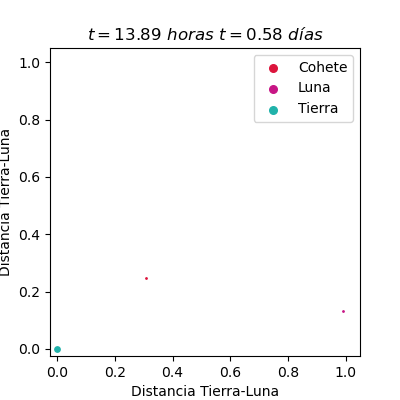

In [17]:
#Animación

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
    
def init():
    ax.set_xlabel("Distancia Tierra-Luna",fontsize=10)
    ax.set_ylabel("Distancia Tierra-Luna",fontsize=10)
    ax.set_xlim(-0.025,1.05)
    ax.set_ylim(-0.025,1.05)

def Update(i):
    
    plot = ax.clear()
    init()
    
    x = redr[i]*np.cos(redphi[i])
    y = redr[i]*np.sin(redphi[i])
    
    plot = ax.set_title(r'$t=%.2f \ horas$' %(redt[i]/3600) + ' ' +r'$t=%.2f \ días$' %(redt[i]/86400) )
    plot = ax.scatter(x, y, color = "crimson", label = "Cohete", s = 1)
    plot = ax.scatter(np.cos(w*redt[i]),np.sin(w*redt[i]), s = 1, color = "mediumvioletred", label = "Luna") 
    plot = ax.scatter(0,0, s = 15, color = "lightseagreen", label = "Tierra")
   
    plot = ax.legend()
    plot.legendHandles[0]._sizes = [30]
    plot.legendHandles[1]._sizes = [30]
    plot.legendHandles[2]._sizes = [30]
            
    return plot
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)